# Feature Regression

In [1]:
from os import listdir,remove
import numpy as np
from tqdm import tqdm
import codecs
import pandas as pd
import re

from sklearn.preprocessing import normalize
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from itertools import combinations
import matplotlib.pyplot as plt
from collections import Counter

import _pickle as pickle
from feature_extraction import TextFeatureCreator,tok_pos_lem_tagging
import spacy


In [2]:
#Class that calculates the features (see feature_extraction.py)
ts = TextFeatureCreator("../data/LSATtexts.txt")

nlp = spacy.load('en_core_web_sm')
clean_path = "/data/ts_cost_function/clean_newsela/"
old_path = "data/newsela/"
#files = [file for file in listdir(clean_path) if file[-3:] == "txt"]

## Load Data and Preprocess

In [12]:
line_break = re.compile(r"(\n|\r|##.*?\r)")
html_tags = re.compile('<.*?>')
dash_lines =  re.compile('-{2,}')
markdown = re.compile('!?\[[^\[]*\]\([^(]+\)')
double_whitespace = re.compile(r"\s+")

In [7]:
def clean_text(text):
    #Use Regex to remove misleading styles
    regex_expressions = [
        line_break,
        html_tags,
        dash_lines,
        markdown,
        double_whitespace
    ]
    
    for regex_expression in regex_expressions:
        text = regex_expression.sub(" ",text)
    
    return text

def clean_files(root,file_names,new_root):
    #Clean text files and save to a new location
    
    for file_name in tqdm(file_names):
        with codecs.open(root+file_name, "r",encoding='utf-8', errors='ignore') as f_read:
            text = f_read.read()
            if text.find("This article has been removed") < 0:
                text = clean_text(text)
                with codecs.open(new_root+file_name, "w",encoding='utf-8', errors='ignore') as f_write:
                    f_write.write(text)
            f_read.close()
            f_write.close()
            
def score_file_text(file_path,cleaning=False):
    #Calculate features for a given text file
    with codecs.open(file_path, "r",encoding='utf-8', errors='ignore') as f:
        text = f.read()
        
        if cleaning:
            text = clean_text(text)
        score = ts.norm_features(ts.get_text_features([text]))
        #score[12] = 1 / score[12]
    return score

### Delete Spanish Files

In [5]:
#delete spanish texts
spanish_files = [file for file in files if file[:-4].split("-")[-3] == "spanish"]
for file in spanish_files:
    remove(newsela_path+"/"+file)

### Clean Files

In [37]:
clean_newsela_path = "/data/ts_cost_function/clean_newsela/"
clean_files("data/newsela/",files,clean_newsela_path)

100%|██████████| 21501/21501 [00:18<00:00, 1148.37it/s]


### Training Newsela

In [12]:
files = [file for file in listdir(clean_path) if file[-3:] == "txt"]

#Loop over all cleaned text files and save their path,name,id and newsela level
files_with_score = []
for file in files:
    split_file_name = file[:-4].split("-")
    file_name = "-".join(split_file_name[:-2])
    file_id = split_file_name[-2]
    level = split_file_name[-1]
    files_with_score += [(clean_newsela_path+file,file_name,file_id,level)]
files_with_score[:5]

[('/data/ts_cost_function/clean_newsela/kea-extinction-21935-540.txt',
  'kea-extinction',
  '21935',
  '540'),
 ('/data/ts_cost_function/clean_newsela/australia-sharks-drones-38904-1390.txt',
  'australia-sharks-drones',
  '38904',
  '1390'),
 ('/data/ts_cost_function/clean_newsela/city-trolley-10561-580.txt',
  'city-trolley',
  '10561',
  '580'),
 ('/data/ts_cost_function/clean_newsela/parkland-students-tony-awards-44221-1020.txt',
  'parkland-students-tony-awards',
  '44221',
  '1020'),
 ('/data/ts_cost_function/clean_newsela/nyc-election-1720-840.txt',
  'nyc-election',
  '1720',
  '840')]

In [ ]:
lines = []
#Score each text and concatenate result with text
for path,article_name,file_id,newsela_score in tqdm(files_with_score):
    
    score = score_file_text(path)
    lines += [np.concatenate([[path,article_name,file_id,newsela_score],score.reshape(-1)])]


In [14]:
#Save the text and the features into a DataFrame for further processing
df = pd.DataFrame(
    data=lines,
    columns=np.concatenate([["path","name","text","newsela_score"],ts.feature_names]))
df[df.columns[3:]] = df[df.columns[3:]].astype(float)
df.head()

,path,name,text,newsela_score,Mean word length,Mean sentence length,Basic english ratio,Syllables per sentence,Type token ratio,#nouns,...,Subordination,Complements,Coordination,Apposition,Passive verbs,Parataxis,Auxiliary Verbs,Negation,Prepositional Phrases,Modifiers
0,/data/ts_cost_function/clean_newsela/kea-extin...,kea-extinction,21935,540.0,0.909090,0.306252,1.298557,0.263046,0.845914,0.365935,...,0.166589,0.603422,0.202795,0.000000,0.256415,0.0,0.366106,0.201348,0.203278,0.256116
1,/data/ts_cost_function/clean_newsela/australia...,australia-sharks-drones,38904,1390.0,0.995979,0.841234,1.016792,0.804812,1.071948,1.044247,...,0.757223,1.234272,0.796094,1.129397,0.437070,0.0,0.950924,0.686415,0.712792,0.855305
2,/data/ts_cost_function/clean_newsela/city-trol...,city-trolley,10561,580.0,0.955849,0.313058,1.250405,0.273918,0.879494,0.373708,...,0.281672,0.360741,0.240468,0.180049,0.278712,0.0,0.440578,0.437714,0.183076,0.306794
3,/data/ts_cost_function/clean_newsela/parkland-...,parkland-students-tony-awards,44221,1020.0,0.846982,0.603712,0.943163,0.505093,0.689046,0.619676,...,0.333178,1.106273,0.442461,1.325159,0.128207,0.0,0.496858,0.805393,0.391068,0.282251
4,/data/ts_cost_function/clean_newsela/nyc-elect...,nyc-election,1720,840.0,0.947809,0.433960,1.017136,0.382856,0.848541,0.602820,...,0.427151,0.551202,0.372263,0.637095,0.493105,0.0,0.440031,0.290406,0.379750,0.316627


### Add LSAT Text to file

In [ ]:
#Define LSAT Score based on the feature sum of the rest of the newsela text 
#(LSAT text should be the most difficult one)
LSAT_score = 1800

copy_df = pd.DataFrame(data=[np.concatenate([["data/LSATtexts.txt","LSAT","0000",LSAT_score],len(ts.feature_names)*[1.0]])],columns=df.columns)
df = df.loc[df["name"] != "LSAT"]
df = pd.concat([df,copy_df])


### Normalize Newsela Score

In [34]:

#Normalize Newsela Scores
df[ts.feature_names+["newsela_score"]] = df[ts.feature_names+["newsela_score"]].astype(float)
df["newsela_score"] = df["newsela_score"] / LSAT_score
df.dtypes

path                       object
name                       object
text                       object
newsela_score             float64
Mean word length          float64
Mean sentence length      float64
Basic english ratio       float64
Syllables per sentence    float64
Type token ratio          float64
#nouns                    float64
#verbs                    float64
#adjectives               float64
#adverbs                  float64
#pronouns                 float64
Subordination             float64
Complements               float64
Coordination              float64
Apposition                float64
Passive verbs             float64
Parataxis                 float64
Auxiliary Verbs           float64
Negation                  float64
Prepositional Phrases     float64
Modifiers                 float64
feature_sums              float64
dtype: object

### Add Feature Sum to DataFrame

In [35]:
df["feature_sums"] = df[ts.feature_names].sum(axis=1)
df["feature_sums"] = pd.to_numeric(df["feature_sums"].values)

df.to_csv("/data/ts_cost_function/newsela_article_features_V2.csv",sep=";",index=False)

## Weebit Corpi

<div class="alert alert-block alert-danger">
**Not Continued**: 

we experimented with the weebit and britishcouncil corpus, before we got access to the newsela corpus. The reason was that both corpi had just a discrete difficulty score (3 levels) for their texts. That made it quite difficult to explore any relation between the features and the score. Therefore, we decided to not use these corpi anymore and focus on the newsela data. Nevertheless, if you are interested in the results you can have a look in the above folder (/code), which contains some of the deprecated notebooks.
</div>

In [52]:
##Existing Weebit Corpi
#weebit_folders

##Example of a scored Weebit Text
#score_file_text("data/weebit/WeeBit-TextOnly/BitGCSE/3644.txt")

['BitGCSE', 'WRLevel4', 'WRLevel3', 'WRLevel2', 'BitKS3']

In [ ]:
#weebit_root = "data/weebit/WeeBit-TextOnly/"
#weebit_folders = listdir(weebit_root)
#weebit_folders.remove(".DS_Store")
#weebit_folders.remove("weebit_articles.zip")
#weebit_data = []

##Loop over each text file
#for folder in tqdm(weebit_folders):
#    curr_path = weebit_root + folder
#    weebit_data += [
#        np.concatenate([
#            [curr_path,file_name],
#            score_file_text(curr_path+"/"+file_name).reshape(-1)]) 
#        for file_name in listdir(curr_path)]

In [ ]:
##Save the result into a DataFrame
#weebit_df = pd.DataFrame(
#    data=weebit_data,
#    columns=np.concatenate([["path","id"],ts.feature_names]))
#
##Be sure that all feature columns have numeric values
#for col in ts.feature_names:
#    weebit_df[col] = pd.to_numeric(weebit_df[col])
#weebit_df["path"] = weebit_df["path"]+"/"+ weebit_df["id"]
#weebit_df.head()

In [66]:
##Remove metadata files
#weebit_df = weebit_df.loc[weebit_df["id"] != ".DS_Store"]
##Remove Inf value rows
#weebit_df = weebit_df.loc[np.isfinite(weebit_df["Basic english ratio"])]

In [67]:
#weebit_df.to_csv("data/weebit_articles_features.csv",index=False,sep=";")

## Plot Result

In [4]:
df = pd.read_csv("/data/ts_cost_function/newsela_article_features_V2.csv",sep=";")
norm_df = df.copy()

In [5]:
norm_df.head()

,path,name,text,newsela_score,Mean word length,Mean sentence length,Basic english ratio,Syllables per sentence,Type token ratio,#nouns,...,Complements,Coordination,Apposition,Passive verbs,Parataxis,Auxiliary Verbs,Negation,Prepositional Phrases,Modifiers,feature_sums
0,/data/ts_cost_function/clean_newsela/kea-extin...,kea-extinction,21935,0.300000,0.909090,0.306252,1.298557,0.263046,0.845914,0.365935,...,0.603422,0.202795,0.000000,0.256415,0.0,0.366106,0.201348,0.203278,0.256116,7.687178
1,/data/ts_cost_function/clean_newsela/australia...,australia-sharks-drones,38904,0.772222,0.995979,0.841234,1.016792,0.804812,1.071948,1.044247,...,1.234272,0.796094,1.129397,0.437070,0.0,0.950924,0.686415,0.712792,0.855305,16.690378
2,/data/ts_cost_function/clean_newsela/city-trol...,city-trolley,10561,0.322222,0.955849,0.313058,1.250405,0.273918,0.879494,0.373708,...,0.360741,0.240468,0.180049,0.278712,0.0,0.440578,0.437714,0.183076,0.306794,8.278258
3,/data/ts_cost_function/clean_newsela/parkland-...,parkland-students-tony-awards,44221,0.566667,0.846982,0.603712,0.943163,0.505093,0.689046,0.619676,...,1.106273,0.442461,1.325159,0.128207,0.0,0.496858,0.805393,0.391068,0.282251,12.440091
4,/data/ts_cost_function/clean_newsela/nyc-elect...,nyc-election,1720,0.466667,0.947809,0.433960,1.017136,0.382856,0.848541,0.602820,...,0.551202,0.372263,0.637095,0.493105,0.0,0.440031,0.290406,0.379750,0.316627,9.679800


### Compare Newsela Score to Feature Sum

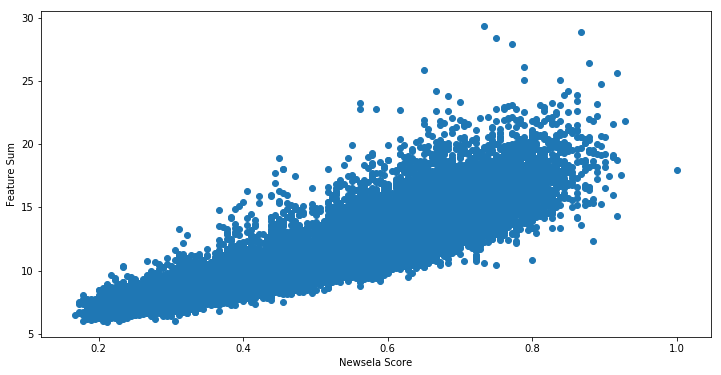

In [12]:
plt.figure(figsize=(12,6))
plt.xlabel("Newsela Score")
plt.ylabel("Feature Sum")
plt.scatter(x=df["newsela_score"],y=df["feature_sums"])

#df.plot.scatter(x="newsela_score",y="feature_sums")

<div class="alert alert-block alert-info">
As you can already see is that just the sum of the different features already is pretty linear. Nevertheless, we didn't rely on this fact and built a regression model to figure out which feature has the biggest impact on the result.
</div>


## Apply Regression Model

* RidgeCV (sklearn): RidgeRegression Algorithm with Cross Validation 

In [3]:
norm_df = pd.read_csv("/data/ts_cost_function/newsela_article_features_V2.csv",sep=";")
norm_df["newsela_score"] = norm_df["newsela_score"].astype(float)

In [4]:
def train_eval_model(train,test,model_fn):
    #Train a regression model and evaluate at the same time
    
    model = model_fn()
    feature_cols = list(train.columns)
    feature_cols.remove("newsela_score")
    model.fit(train[feature_cols],train["newsela_score"])
    
    print("Evaluation: \n Feature Importance:")
        
    for row in zip(*[feature_cols,model.coef_]):
        print(row)
    print("Train Accuracy: ")
    print(model.score(train[feature_cols],
                    train["newsela_score"]))
    print("Test Accuracy: ")
    print(model.score(test[feature_cols],
                    test["newsela_score"]))
    
    return model

def eval_exclude_cols(df,feature_cols,exclude,test,model_fn):
    #Makes it possible to specifically exclude different features from the regression
    #(useful to see if the regression is also possible without the strong influence of e.g. sentence length)
    
    col_without = feature_cols
    bool_without = [col not in exclude for col in col_without]
    col_without = col_without[bool_without]
    #print(col_without,bool_without)
    train = df[["newsela_score"] + list(col_without)]
    
    return train_eval_model(
        train,test,model_fn)

### Compare Prediction to Actual Newsela Score

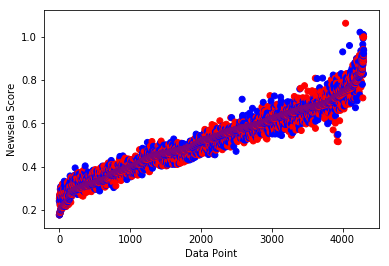

R2 Coefficient: 0.9492815218167757


In [8]:
#Put the newsela_scores into different bins (n=50) to get a stratified plot 
y_bins = np.digitize(norm_df["newsela_score"]*1800, np.linspace(0,1,50))
y_bins[-1] = np.sort(y_bins)[-2]

#Test and Training Set
train,test = train_test_split(
    norm_df[["newsela_score"] + list(ts.feature_names)],
    stratify=y_bins,
    test_size=0.2,
    random_state=0)
test_sorted = test.sort_values("newsela_score")

#Learn Model
model = linear_model.RidgeCV()
model.fit(train[ts.feature_names],train["newsela_score"])
predictions = model.predict(test_sorted[ts.feature_names])

#Plot the predictions compared to the test score 
plt.scatter(
    x=[range(len(test)),range(len(test))],
    y=[predictions,test_sorted["newsela_score"]],
    c=["blue","red"])
plt.xlabel("Data Point")
plt.ylabel("Newsela Score")
plt.show()
print("R2 Coefficient: {}".format(
    model.score(test[ts.feature_names],test['newsela_score'])))

<div class="alert alert-block alert-info">
The plot shows the relation between the prediction and the actual newsela score for all data points in the test set. It shows the good predictable performance of our regression model. In the next part, we will explore which feature is most responsible for the score.
</div>

### Feature Influence on the Result

#### RidgeCV without excluding columns

In [10]:

model = eval_exclude_cols(
    train,
    np.array(ts.feature_names),
    [],
    test,
    linear_model.RidgeCV
)

Evaluation: 
 Feature Importance:
('Mean word length', 0.39356410746008924)
('Mean sentence length', 0.7222952743899624)
('Basic english ratio', -0.14877576762926953)
('Syllables per sentence', -0.4076744578611754)
('Type token ratio', -0.05000802991653566)
('#nouns', 0.11054778770527518)
('#verbs', 0.07535225250179556)
('#adjectives', 0.03514014812578814)
('#adverbs', 0.029284138845135033)
('#pronouns', -0.009701784994580187)
('Subordination', 0.037030318994935696)
('Complements', 0.006765304049278775)
('Coordination', 0.03316257858082694)
('Apposition', -0.003686813952598289)
('Passive verbs', -0.005871767921674986)
('Parataxis', 0.001284720917590576)
('Auxiliary Verbs', 0.01267303268524067)
('Negation', -0.00984990984653944)
('Prepositional Phrases', 0.02877578216408383)
('Modifiers', 0.019285124086740213)
Train Accuracy: 
0.9489178362500537
Test Accuracy: 
0.9492815218167757


Here you can see the weights applied to each feature to produce the regression score. Higher absolute numbers indicate a stronger influence on the result. As you can see mean sentence length, mean word length, sylabbles per sentence and basic english ratio have the highest impact on the result. Let's see how the model adapts if we remove these four. (see below)

#### RidgeCV without the four most important features


In [13]:
model = eval_exclude_cols(
    train,
    np.array(ts.feature_names),
    ['Mean sentence length','Mean word length','Syllables per sentence','Basic english ratio'],
    test,
    linear_model.RidgeCV
)

Evaluation: 
 Feature Importance:
('Type token ratio', -0.06857308675251533)
('#nouns', 0.3133997907861037)
('#verbs', 0.20973225285190034)
('#adjectives', 0.08172010165039145)
('#adverbs', 0.045075136621536505)
('#pronouns', -0.002137245894477058)
('Subordination', 0.017668436371609086)
('Complements', -0.005968083229419108)
('Coordination', 0.042123973378698665)
('Apposition', -0.0006114561310610611)
('Passive verbs', 0.0013338797128141788)
('Parataxis', 0.001789679038420644)
('Auxiliary Verbs', 0.0030202101838339157)
('Negation', -0.013542333965890663)
('Prepositional Phrases', 0.06737885368010921)
('Modifiers', 0.03834440288841967)
Train Accuracy: 
0.9304704776886893
Test Accuracy: 
0.9302596957930754


The total accuracy (see in the bottom "Train Accuracy" and "Test Accuracy") just dropped by 2%, with means that the rest of the features can compensate the missing most important features.

In [59]:
#Add the regression_score to the DataFrame
norm_df["regression_score"] = model.predict(norm_df[ts.feature_names])

#Save to file
norm_df[["path","feature_sums","regression_score"]+ts.feature_names].to_csv(
    "/data/ts_cost_function/newsela_article_feature_scores_V2.csv",
    sep=";",
    index=False)

### Weebit Data

In [113]:
#Predict the scores for the Weebit corpus
weebit_df = pd.read_csv("data/weebit_articles_features.csv",sep=";")
weebit_df["regression_score"] = model.predict(weebit_df[ts.feature_names])
weebit_df["feature_sums"] = weebit_df[ts.feature_names].sum(axis=1)

weebit_df["group"] = [row[3] for row in weebit_df["path"].str.split("/")]

#### Regression Score in different Datasets

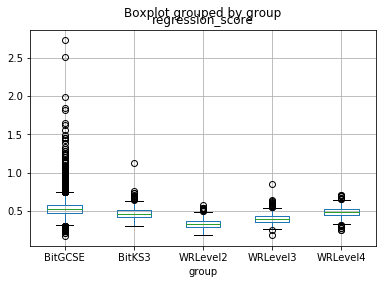

In [132]:
#Plot the regression score in different datasets
weebit_df.loc[
    (weebit_df["regression_score"] < 10)
].boxplot(column="regression_score",by="group")

<div class="alert alert-block alert-info">
We tested our regression score on the Weebit corpus and saw that the score increases for the different text difficulty levels (WRLevel2-4). That is a small indicator that the regression score even works for texts outside of the domain. Nevertheless, there are several texts with a score higher 1, which is not desired. In the next steps. We print out some examples of these texts.
</div>

#### Feature Sum in different Datasets

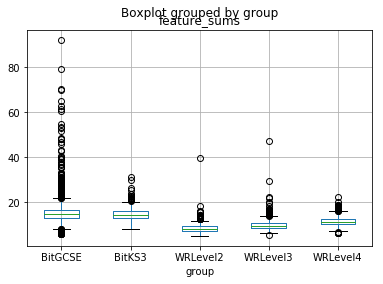

In [135]:
#Same Experiment with the Feature Sum
weebit_df.loc[
    (weebit_df["feature_sums"] < 100)].boxplot(column="feature_sums",by="group")

#### Show Text with a higher score than usual (usual: 0-1)

In [140]:
#which texts have a really high regression score?
high_value_df = weebit_df.loc[
    (weebit_df["regression_score"] > 1.5) &
    (weebit_df["regression_score"] < 2)]

In [142]:
for ind,row in high_value_df.iterrows():
    with open(row["path"],"r") as f:
        print(f.read())

Addition, subtraction, multiplication and division - Foundation
Addition, subtraction, multiplication and division - Foundation
yourself on Addition, subtraction, multiplication and division - Foundation
Addition, subtraction, multiplication and division - Higher
Addition, subtraction, multiplication and division - Higher
yourself on Addition, subtraction, multiplication and division - Higher
yourself on Converting fractions, decimals and percentages
yourself on Powers and roots - Foundation
yourself on Powers and roots - Higher

Moniza Alvi: Presents from my Aunts in Pakistan
Moniza Alvi: Presents from my Aunts in Pakistan
on Moniza Alvi: Presents from my Aunts in Pakistan
on Nissim Ezekiel: Night of the Scorpion
yourself on Nissim Ezekiel: Night of the Scorpion
Lawrence Ferlinghetti: Two Scavengers in a Truck...
Lawrence Ferlinghetti: Two Scavengers in a Truck...
on Lawrence Ferlinghetti: Two Scavengers in a Truck...
yourself on Lawrence Ferlinghetti: Two Scavengers in a Truck...
Suj

<div class="alert alert-block alert-info">
The shown text have a really high regression score, which shouldn't happen. Most of the texts seems to have duplicated sentences and don't really follow the structure of a ordninary news article. In a conclusion, even if these texts exceed our threshold we could show that they doesn't represent the overall majority of texts. That is another reason why we excluded the Weebit corpus from our research (next to the fact that we only have 3 levels of difficulty).
</div>

## Feature Correlation

In [6]:
norm_df = pd.read_csv("/data/ts_cost_function/newsela_article_feature_scores_V2.csv",sep=";")

### Plot Correlation Matrix

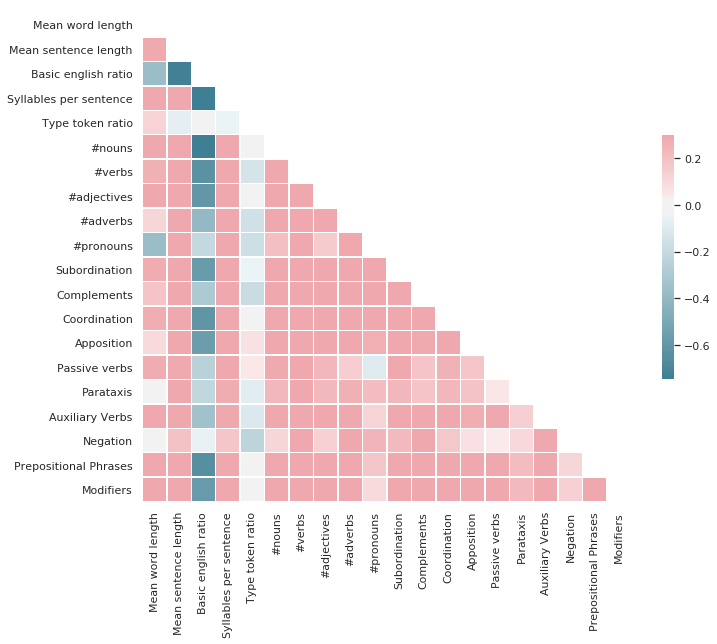

In [7]:
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white")

# Generate a large random dataset
rs = np.random.RandomState(33)
d = norm_df[ts.feature_names]

# Compute the correlation matrix
corr = d.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

<div class="alert alert-block alert-info">
The confusion matrix shows the relation of the different text features. It seems to be that most of them have a slightly negative relation (higher row --> smaller column). On the one hand, the negative effects can mostly be ignored, because the value is not higher than indicated in the scale on the right: 0,2 . On the other hand, the basic english ratio seems to be stronger correlated to most of the other features. The reason for that could be that longer texts (which is mostly an indicator for a more difficult text) have overall a higher proportion of basic english words, just because of the higher number of words that could be basic english words.
</div>